In [79]:
from typing import Union
import numpy as np
import pandas as pd
import numpy.typing as npt
from typing import Tuple
from tqdm import tqdm
from matplotlib import pyplot as plt
from simulations.stochastic_models import StochasticModels
from utility.types import StochasticModelEnum
from utility.math_equations import (
    compute_currrent_step_log_price,
    compute_next_step_log_vol,
)
from data_provider.data_provider import DataProvider
from filters.kalman_filter import LinearKalmanFilterND
from filters.unscented_kalman_filter import UnscentedKalmanFilter

In [82]:
df = DataProvider.get_stochastic_fake_data()
df

,Date,prices,returns,vol,volvol
58,0.230159,78.252391,0.045775,0.021141,0.005829
59,0.234127,76.440999,-0.023148,0.021456,0.005485
60,0.238095,80.395499,0.051733,0.023196,0.005015
61,0.242063,78.987222,-0.017517,0.023234,0.004716
62,0.246032,77.884119,-0.013966,0.023391,0.004492
...,...,...,...,...,...
996,3.952381,562.502008,-0.015881,0.024314,0.001794
997,3.956349,587.040667,0.043624,0.024599,0.001762
998,3.960317,589.117335,0.003538,0.024616,0.001707
999,3.964286,568.644547,-0.034752,0.025897,0.001602


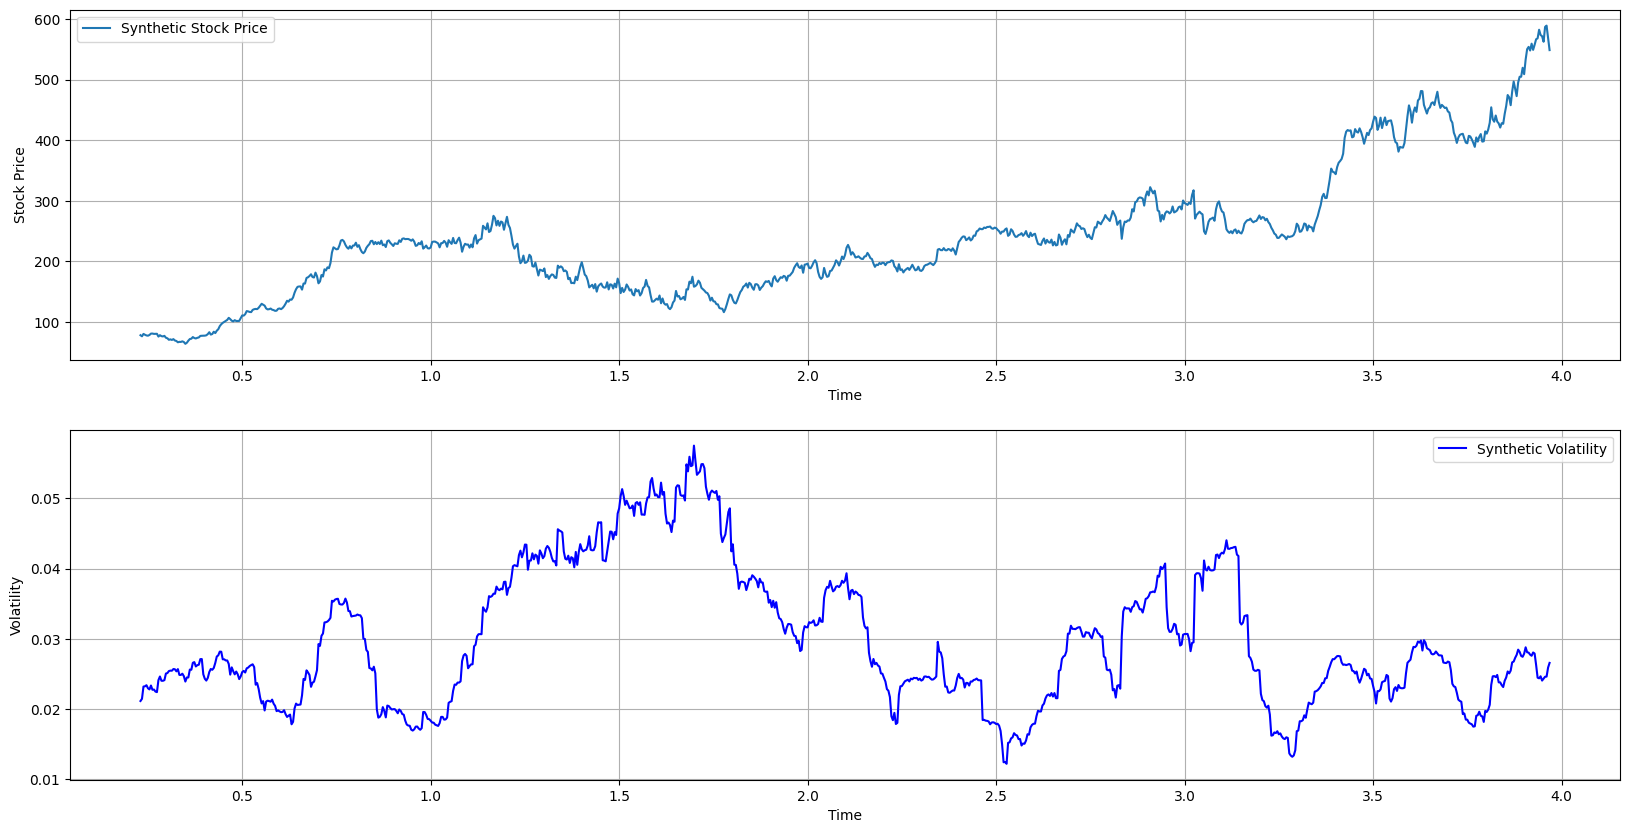

In [83]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(df.Date, df.prices, label="Synthetic Stock Price")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Stock Price")
ax[0].legend()
ax[0].grid()

ax[1].plot(df.Date, df.vol, color="blue", label="Synthetic Volatility")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Volatility")
ax[1].legend()
ax[1].grid()

In [63]:
import numpy as np

N = 10
X = np.zeros((N, 1))
V = np.zeros((N, 1))
V[0] = 20**2
V[1] = 20**2
X[0] = 100
X[1] = 101
dW, dZ = StochasticModels.generate_two_correlated_brownian(-0.3, X.shape[0], dt=1)
Z = np.cumsum(dZ)
W = np.cumsum(dW)
# # order [kappa, theta, xi, rho, mu, p, ]
# LEARNABLE_PARAMS = [4, 0.27, 0.99, -0.3, 0.3, 0.5]
#  x_k[0],  # log vol at time t
#                     x_k[1],  # log vol at time t-1
#                     x_k[2],  # log vol at time t-2
#                     u_k[0],  # brownian motion at time t
#                     self.w[0],  # kappa
#                     self.w[1],  # theta
#                     self.w[2],  # xi
#                     self.w[3],  # rho
#                     self.w[4],  # mu
#                     self.w[5],  # p
# for i in tqdm(range(2,X.shape[0]-2)):
#     log_vol = np.log(V[i]) + 4*(13-V[i-1])*1 + 11 *V[i-1]**1 * dZ[i-1] #compute_next_step_log_vol(np.log(V[i-1]),X[i-1],X[i-2],Z[i-1],4,0.27,0.99,-0.3,0.3,1,1)
#     print(log_vol)
#     log_price = compute_currrent_step_log_price(np.log(X[i-1]),log_vol,W[i-1],1)
#     X[i] = np.exp(log_price)
#     V[i] = np.exp(log_vol)
# 2*k*theta> xi^2

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\bzloch\AppData\Local\Temp\ipykernel_19160\2013706793.py:25: RuntimeWarning: divide by zero encountered in log
  log_vol = np.log(V[i]) + 4*(13-V[i-1])*1 + 11 *V[i-1]**1 * dZ[i-1] #compute_next_step_log_vol(np.log(V[i-1]),X[i-1],X[i-2],Z[i-1],4,0.27,0.99,-0.3,0.3,1,1)
100%|██████████| 6/6 [00:00<00:00, 2355.47it/s]

[-inf]
[-inf]
[-inf]
[-inf]
[-inf]
[-inf]


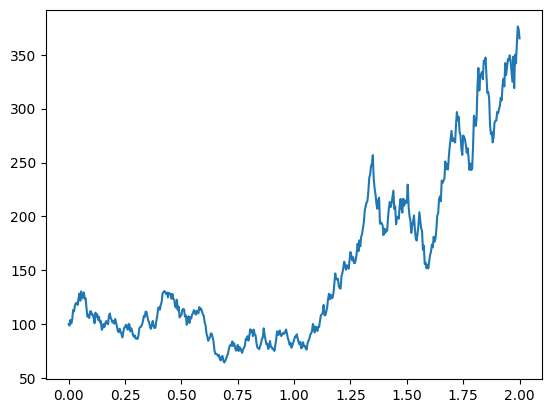

In [109]:
def simulate_heston_process_with_jump(
    T: float = 2,
    s0: float = 100,
    kappa: float = 4,
    theta: float = 0.27,
    xi: float = 0.99,
    rho: float = -0.2,
    mu: float = 0.3,
) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    """Generate a Heston model path with jumps.

    Args:
    -----
        T (int, optional): The horizon in years. Defaults to 2.
        s0 (float, optional): The starting point value. Defaults to 100.
        kappa (float, optional): Mean reversion speed. Defaults to 4.
        theta (float, optional): Long-run mean of variance. Defaults to 0.27.
        xi (float, optional): Volatility of volatility. Defaults to 0.99.
        rho (float, optional): Correlation between asset price and variance. Defaults to -0.2.
        mu (float, optional): The average growth rate by year. Defaults to 0.3.


    Returns:
    -----
        Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64]]: The time, the asset price and the volatility paths.
    """
    assert 2 * kappa * theta > xi**2, "Feller condition not satisfied"
    # Initialize variables
    n_steps = int(252 * T)
    dt = T / n_steps
    S = np.zeros(n_steps + 1)
    V = np.zeros(n_steps + 1)

    # Generate correlated Brownian motions
    dW = np.random.multivariate_normal(
        [0, 0], [[dt, rho * dt], [rho * dt, dt]], size=(n_steps + 1,)
    )

    # Generate asset price and volatility paths
    S[0] = s0
    V[0] = theta
    for i in tqdm(
        range(1, n_steps + 1), desc="Generating path", total=n_steps, leave=False
    ):
        V[i] = compute_current_variance(V[i - 1], kappa, theta, xi, dt, dW[i, 0])
        S[i] = compute_current_price(S[i - 1], V[i - 1], mu, dt, dW[i, 1])

    t = np.linspace(0, T, n_steps + 1)
    return t, S, V




t, S, V = simulate_heston_process_with_jump()
plt.plot(t, S)

In [88]:
# Generate correlated Brownian motions
T = 2
dt = 1
n_steps = 252 * T
s0 = 100
theta = 0.27
kappa = 4
xi = 0.99
rho = -0.2
mu = 0.05

S = np.zeros((n_steps + 1,))
V = np.zeros((n_steps + 1,))
dW = np.random.multivariate_normal(
    [0, 0], [[dt, rho * dt], [rho * dt, dt]], size=(n_steps + 1,)
)


# Generate asset price and volatility paths
S[0] = s0
V[0] = theta
for i in tqdm(
    range(1, n_steps + 1), desc="Generating path", total=n_steps, leave=False
):
    V[i] = V[i - 1] + (
        kappa * (theta - V[i - 1]) * dt + xi * np.sqrt(np.abs(V[i - 1])) * dW[i, 0]
    )
    S[i] = S[i - 1] * (
        np.exp((mu - 0.5 * V[i - 1]) * dt + np.sqrt(np.abs(V[i - 1])) * dW[i, 1])
    )
t = np.linspace(0, T, n_steps + 1)
t, S, V

Generating path:   0%|          | 0/504 [00:00<?, ?it/s]C:\Users\bzloch\AppData\Local\Temp\ipykernel_19160\1878785590.py:33: RuntimeWarning: overflow encountered in exp
  np.exp(
C:\Users\bzloch\AppData\Local\Temp\ipykernel_19160\1878785590.py:32: RuntimeWarning: invalid value encountered in scalar multiply
  S[i] = S[i - 1] * (


(array([0.        , 0.00396825, 0.00793651, 0.01190476, 0.01587302,
        0.01984127, 0.02380952, 0.02777778, 0.03174603, 0.03571429,
        0.03968254, 0.04365079, 0.04761905, 0.0515873 , 0.05555556,
        0.05952381, 0.06349206, 0.06746032, 0.07142857, 0.07539683,
        0.07936508, 0.08333333, 0.08730159, 0.09126984, 0.0952381 ,
        0.09920635, 0.1031746 , 0.10714286, 0.11111111, 0.11507937,
        0.11904762, 0.12301587, 0.12698413, 0.13095238, 0.13492063,
        0.13888889, 0.14285714, 0.1468254 , 0.15079365, 0.1547619 ,
        0.15873016, 0.16269841, 0.16666667, 0.17063492, 0.17460317,
        0.17857143, 0.18253968, 0.18650794, 0.19047619, 0.19444444,
        0.1984127 , 0.20238095, 0.20634921, 0.21031746, 0.21428571,
        0.21825397, 0.22222222, 0.22619048, 0.23015873, 0.23412698,
        0.23809524, 0.24206349, 0.24603175, 0.25      , 0.25396825,
        0.25793651, 0.26190476, 0.26587302, 0.26984127, 0.27380952,
        0.27777778, 0.28174603, 0.28571429, 0.28

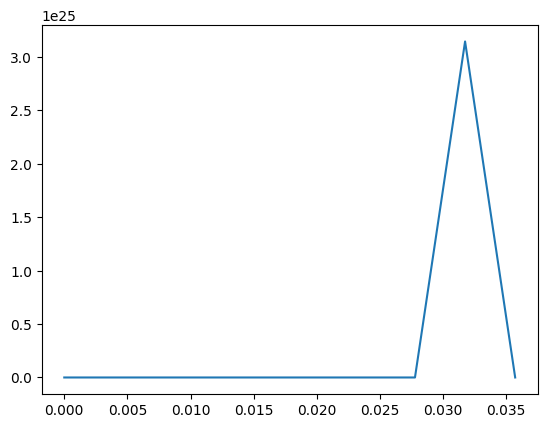

In [89]:
plt.plot(t, S, label="Asset price")

## SImple example


In [ ]:
Z = df[["prices", "vol"]].to_numpy()

ukf = UnscentedKalmanFilter(
    dim_x=Z.shape[-1],
    dim_z=Z.shape[-1],
    Q=np.array([[5, 0.0], [0.0, 10]]),
    R=np.array([[5, 0.0], [0.0, 10]]),
)


def f(x, u, v):
    return x + u + v


def h(x, u, n):
    return x + u + n


X_hat, _ = ukf.fit_predict(f, h, z=Z, x0=Z[0])

N = 100
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].set_title("Kalman Filter Estimation of Stock Price")

ax[0].plot(
    df.t[-N:], df.prices[-N:], color="red", label="Synthetic Stock Price", alpha=0.8
)
ax[0].plot(
    df.t[-N:],
    X_hat[-N:, 0],
    color="blue",
    label="UKF State Stock Price",
    alpha=0.8,
    linestyle="--",
)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Stock Price")
ax[0].legend()
ax[0].grid()

ax[1].plot(
    df.t[-N:], df.vol[-N:], color="red", label="Stochastic Volatility", alpha=0.8
)
ax[1].plot(
    df.t[-N:],
    X_hat[-N:, -1],
    color="blue",
    label="UKF StateVolatility",
    alpha=0.8,
    linestyle="--",
)
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Volatility")
ax[1].legend()
ax[1].grid()

## Our SSM


In [ ]:
from typing import List
from filters.ssm import DSSM

# order [kappa, theta, xi, rho, mu, p, ]
LEARNABLE_PARAMS = [4, 0.27, 0.99, -0.3, 0.3, 0.5]

dssm = DSSM(LEARNABLE_PARAMS)

In [ ]:
df["prices_t_1"] = df.prices.shift(1)
Z = df[["vol", "prices", "prices_t_1"]].dropna().to_numpy()

In [ ]:
ukf = UnscentedKalmanFilter(
    dim_x=3,
    dim_z=3,
    Q=np.array([[10, 0.0, 0.0], [0.0, 10.0, 0.0], [0.0, 0.0, 10.0]]),
    R=np.array([[5, 0.0, 0.0], [0.0, 5.0, 0.0], [0.0, 0.0, 5.0]]),
)

X_hat, _, X_hat_estim = ukf.fit_predict(
    dssm.f,
    dssm.h,
    z=Z,
    u=np.stack(
        StochasticModels.generate_two_correlated_brownian(-0.3, Z.shape[0]), axis=1
    ),
    x0=df[["vol", "prices", "prices_t_1"]].dropna().to_numpy()[0],
    verbose=False,
    keep_state_estimates=True,
)

In [ ]:
N = 100
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].set_title("Kalman Filter Estimation of Stock Price")

ax[0].plot(
    df.t[-N:], df.prices[-N:], color="red", label="Synthetic Stock Price", alpha=0.8
)
ax[0].plot(
    df.t[-N:],
    X_hat[-N:, 1],
    color="blue",
    label="UKF State Stock Price",
    alpha=0.8,
    linestyle="--",
)
ax[0].plot(
    df.t[-N:],
    X_hat_estim[-N:, 1],
    color="green",
    label="UKF State Stock Price estimated only",
    alpha=0.8,
    linestyle="--",
)

ax[0].set_xlabel("Time")
ax[0].set_ylabel("Stock Price")
ax[0].legend()
ax[0].grid()

ax[1].plot(
    df.t[-N:], df.vol[-N:], color="red", label="Stochastic Volatility", alpha=0.8
)

ax[1].plot(
    df.t[-N:],
    X_hat[-N:, 0],
    color="blue",
    label="UKF State Volatility",
    alpha=0.8,
    linestyle="--",
)
ax[1].plot(
    df.t[-N:],
    X_hat_estim[-N:, 0],
    color="green",
    label="UKF State Volatility estimated only",
    alpha=0.8,
    linestyle="--",
)


ax[1].set_xlabel("Time")
ax[1].set_ylabel("Volatility")
ax[1].legend()
ax[1].grid()

In [ ]:
# ukf = UnscentedKalmanFilter(
#     dim_x=3,
#     dim_z=1,
#     Q=np.array([[5, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]),
#     R=np.array([[5]]),
# )

# X_hat, _ = ukf.fit_predict(
#     dssm.f,
#     dssm.h,
#     z=Z,
#     u=np.stack(
#         StochasticModels.generate_two_correlated_brownian(-0.3, Z.shape[0]), axis=1
#     ),
#     x0=df[["vol","prices", "prices_t_1"]].dropna().to_numpy()[0],
# )
# # print(x, K, z, y)
# # x = x + (K @ (z - y))

In [ ]:
# Z = df[["prices", "vol"]].to_numpy()

# ukf = UnscentedKalmanFilter(
#     dim_x=Z.shape[-1],
#     dim_z=Z.shape[-1],
#     Q=np.array([[5, 0.0], [0.0, 10]]),
#     R=np.array([[5, 0.0], [0.0, 10]]),
# )


# def f(x, u, v):
#     return x + u + v


# def h(x, u, n):
#     return x + u + n


# X_hat, _ = ukf.fit_predict(f, h, z=Z)